## **MODELING**

This notebook implements machine learning models based on the comprehensive **EDA findings** and **preprocessing recommendations**.
We follow an **evidence-based approach** to ensure the modeling strategy aligns with the data characteristics and patterns identified earlier.

### **Modeling Strategy**

* **Model Selection** – Logistic Regression (baseline), Random Forest, and XGBoost (as recommended by EDA)
* **Hyperparameter Tuning** – `StratifiedKFold` cross-validation optimizing for **Macro F1-score**
* **Class Imbalance Handling** – Balanced class weights and **stratified sampling** during training
* **Feature Importance** – Validate high-signal and engineered features identified in EDA
* **Model Evaluation** – Confusion matrix, classification report, ROC-AUC, balanced accuracy, and macro F1
* **Explainability** – SHAP values and model coefficients for feature interpretation


### **EDA Evidence for Modeling**

| EDA Finding                 | Modeling Implication                                                                    |
| --------------------------- | --------------------------------------------------------------------------------------- |
| **Non-linear interactions** | Use tree-based models (Random Forest, XGBoost) to capture complex feature relationships |
| **Class imbalance**         | Apply stratified sampling and evaluate with balanced metrics                            |
| **Feature engineering**     | Validate derived variables such as `Total_Income`, `Loan_to_Income`, and `EMI`          |
| **Outlier impact**          | Use `RobustScaler` and IQR-based clipping; ensemble models are more robust              |
| **Production focus**        | Select interpretable and stable models suitable for deployment and policy insights      |

#### **1. Import Libraries and Load Preprocessed Data**


In [1]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,balanced_accuracy_score, accuracy_score,f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import joblib

# advanced ML libraries
try: 
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost is not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTBM_AVAILABLE = True
except ImportError:
    LIGHTBM_AVAILABLE = False
    print("LightGBM is not available. Install with: pip install lightgbm")
    
# explainability 
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP is not available. Install with: pip install shap")

# set style for better visualizations
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("All libraries imported successfully.") 
print(f"XGBoost available: {XGBOOST_AVAILABLE}, LightGBM available: {LIGHTBM_AVAILABLE}, SHAP available: {SHAP_AVAILABLE}")
      


SHAP is not available. Install with: pip install shap
All libraries imported successfully.
XGBoost available: True, LightGBM available: True, SHAP available: False


In [2]:
# load preprocessed data
print("LOADING PREPROCESSED DATA")
try:
    X_train = pd.read_csv("scaled_X_train.csv")
    X_test = pd.read_csv("scaled_X_test.csv")
    y_train = pd.read_csv("y_train.csv").squeeze()
    y_test = pd.read_csv("y_test.csv").squeeze()
    
    
    # loading preprocessing objects
    scaler = joblib.load("robust_scaler.pkl")
    selected_features = joblib.load("selected_features.pkl")
    
    print("Preprocessed data loaded successfully.")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # display class distribution
    print("Class Distribution: ")
    print("Training set: ")
    print(y_train.value_counts().sort_index())
    print("Test set: ")
    print(y_test.value_counts().sort_index())
    
    # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")
        
except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: scaled_X_train.csv, scaled_X_test.csv")
    print("                y_train.csv, y_test.csv")
    print("                robust_scaler.pkl, selected_features.pkl")
    
    

LOADING PREPROCESSED DATA
Preprocessed data loaded successfully.
Training set: (675, 16)
Test set: (169, 16)
Class Distribution: 
Training set: 
Loan_Status
0    328
1    347
Name: count, dtype: int64
Test set: 
Loan_Status
0    94
1    75
Name: count, dtype: int64

Selected features (15):
 1. Gender
 2. Married
 3. Dependents
 4. Education
 5. Self_Employed
 6. Credit_History
 7. Property_Area
 8. Loan_Amount_Term_Year
 9. Marital_status
10. Income_category
11. ApplicantIncome_log
12. CoapplicantIncome_log
13. LoanAmount_log
14. Total_Income_log
15. EMI_log


#### **2. Baseline Model - Logistic Regression**


In [3]:
# Baseline Logistic Regression model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction")

# Create and train baseline model
baseline_model = LogisticRegression(
    random_state=234,
    max_iter=1000
    # class_weight='balanced'  # Handle class imbalance as recommended by EDA
)

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='binary')
test_f1 = f1_score(y_test, y_test_pred, average='binary')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, Balanced Acc: {train_balanced_acc:.3f}, Binary F1: {train_f1:.3f}")
print(f"Test - Accuracy: {test_accuracy:.3f}, Balanced Acc: {test_balanced_acc:.3f}, Binary F1: {test_f1:.3f}")

# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'train_balanced_acc': train_balanced_acc,
    'test_balanced_acc': test_balanced_acc,
    'train_f1': train_f1,
    'test_f1': test_f1
}

print(".... Baseline model completed!")


BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction



Baseline Model Performance:
Training - Accuracy: 0.785, Balanced Acc: 0.781, Binary F1: 0.817
Test - Accuracy: 0.751, Balanced Acc: 0.771, Binary F1: 0.772

Feature Coefficients (Top 10):
 1. Credit_History: 3.879
 2. Self_Employed: 0.961
 3. CoapplicantIncome_log: 0.598
 4. EMI_log: -0.450
 5. Property_Area: 0.434
 6. Marital_status: 0.381
 7. Married: 0.381
 8. Total_Income_log: -0.235
 9. ApplicantIncome_log: 0.206
10. Education: -0.181
.... Baseline model completed!


### **3. Random Forest Classifier (EDA Recommendation)**

Random Forest Classifier
EDA Recommendation: RObust, captures interactions, insensitive to scaling and moderate outliers



Random Forest Performance
Training Accuracy: 1.000, Balanced Acc: 1.000, Macro F1: 1.000
Test Accuracy: 0.775, Balanced Acc: 0.787, Macro F10.775

 Feature Importance (Top 10)
1.000000. Credit_History: 0.287
2.000000. Total_Income_log: 0.106
3.000000. ApplicantIncome_log: 0.101
4.000000. EMI_log: 0.099
5.000000. LoanAmount_log: 0.090
6.000000. Unnamed: 0: 0.084
7.000000. CoapplicantIncome_log: 0.065
8.000000. Property_Area: 0.028
9.000000. Dependents: 0.027
10.000000. Loan_Amount_Term_Year: 0.025


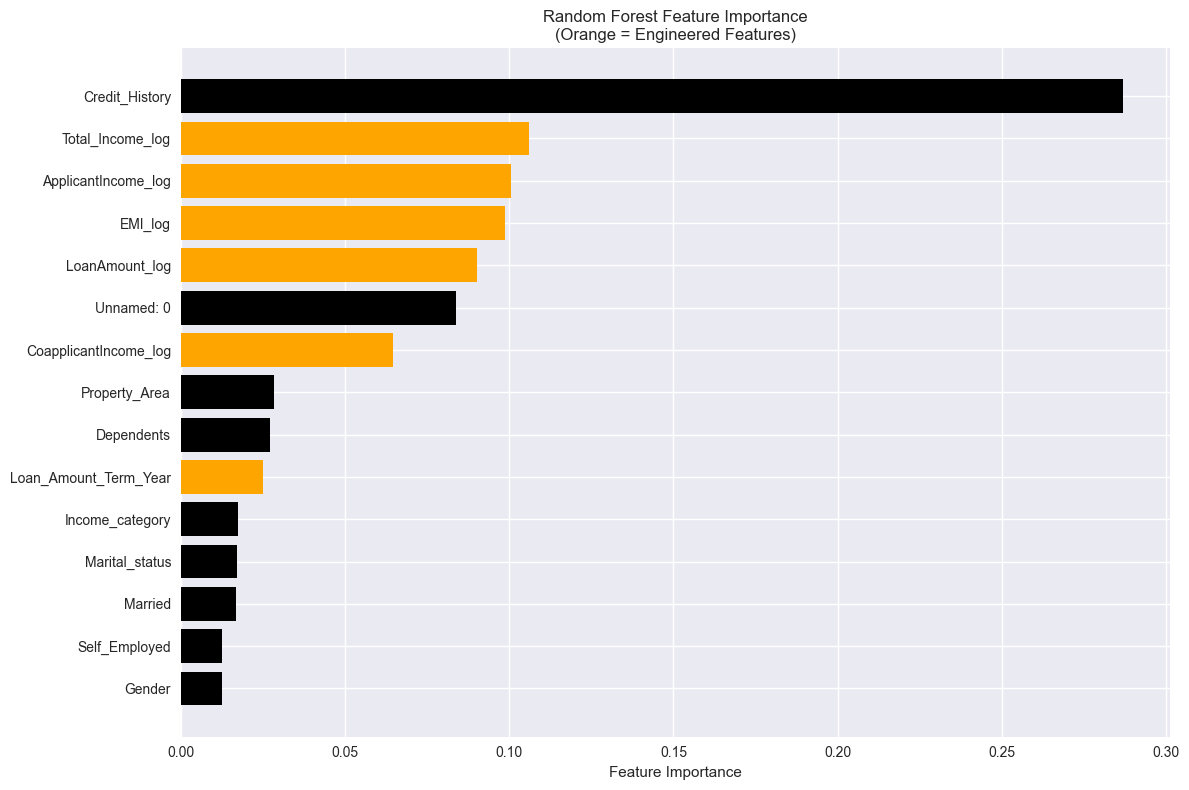

...Random Forest model completed...


In [8]:
# Random Forest classifier
print("Random Forest Classifier")
print("EDA Recommendation: RObust, captures interactions, insensitive to scaling and moderate outliers")

# create Random Forest model
rf_model = RandomForestClassifier(
    n_estimators = 100,
    random_state = 42,
    class_weight = "balanced", # handle class imbalance
    n_jobs = -1 # use all available cores
)


# train the model
rf_model.fit(X_train, y_train)

# make prediction
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

train_balanced_acc_rf = balanced_accuracy_score(y_train, y_train_pred_rf)
test_balanced_acc_rf = balanced_accuracy_score(y_test, y_test_pred_rf)


train_f1_rf = f1_score(y_train, y_train_pred_rf, average = "macro")
test_f1_rf = f1_score(y_test, y_test_pred_rf, average = "macro")

print(f"\nRandom Forest Performance")
print(f"Training Accuracy: {train_accuracy_rf:.3f}, Balanced Acc: {train_balanced_acc_rf:.3f}, Macro F1: {train_f1_rf:.3f}")
print(f"Test Accuracy: {test_accuracy_rf:.3f}, Balanced Acc: {test_balanced_acc_rf:.3f}, Macro F1{test_f1_rf:.3f}")

# feature importance analysis
print(f"\n Feature Importance (Top 10)")

feature_importance_rf = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False)


for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2f}. {row["feature"]}: {row["importance"]:.3f}")
    
#visualize feature importance
plt.figure(figsize = (12,8))
top_features_rf = feature_importance_rf.head(15) 


colors = ["orange" if any(keyword in f.lower() for keyword in ["total", "log","year"]) else "black" for f in top_features_rf["feature"]]

plt.barh(range(len(top_features_rf)), top_features_rf["importance"], color = colors)
plt.yticks(range(len(top_features_rf)),top_features_rf["feature"])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance\n(Orange = Engineered Features)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# store rndom forest result
rf_results = {
    "model": "Random Forest",
    "train_accuracy":train_accuracy_rf,
    "test_accuracy": test_accuracy_rf,
    "train_balanced_acc": train_balanced_acc_rf,
    "test_balanced_acc":test_balanced_acc_rf,
    "train_f1":train_f1_rf,
    "test_f1": test_f1_rf
    
    }

print("...Random Forest model completed...")

### **4. XGBoost Classifier (EDA Recommendation)**